In [17]:
import numpy as np
import cupy as cp
import dxchange
import matplotlib.pyplot as plt
from holotomo.holo import G, GT
from holotomo.magnification import M, MT
from holotomo.shift import S, ST, registration_shift
from holotomo.chunking import gpu_batch
from holotomo.recon_methods import CTFPurePhase, multiPaganin
from holotomo.proc import dai_yuan, linear
import holotomo.chunking as chunking


%matplotlib inline

cp.cuda.Device(0).use()
chunking.global_chunk = 1

# Init data sizes and parametes of the PXM of ID16A

In [18]:
n = 1024  # object size in each dimension
ntheta = 1  # number of angles (rotations)

center = n/2  # rotation axis

npos = 3  # number of code positions 

detector_pixelsize = 3e-6
energy = 33.35  # [keV] xray energy
wavelength = 1.2398419840550367e-09/energy  # [m] wave length

focusToDetectorDistance = 1.28  # [m]
sx0 = 3.7e-4
z1 = 4.584e-3-sx0#np.array([4.584e-3, 4.765e-3, 5.488e-3, 6.9895e-3])[:npos]-sx0
z1 = np.tile(z1,[npos])
z2 = focusToDetectorDistance-z1
distances = (z1*z2)/focusToDetectorDistance
magnifications = focusToDetectorDistance/z1
voxelsize = detector_pixelsize/magnifications[0]*2048/n  # object voxel size

norm_magnifications = magnifications/magnifications[0]
# scaled propagation distances due to magnified probes
distances = distances*norm_magnifications**2

z1p = 8e-3  # positions of the code and the probe for reconstruction

z2p = z1-np.tile(z1p, len(z1))
# magnification when propagating from the probe plane to the detector
magnifications2 = z1/z1p
# propagation distances after switching from the point source wave to plane wave,
distances2 = (z1p*z2p)/(z1p+z2p)
norm_magnifications2 = magnifications2/(z1p/z1[0])  # normalized magnifications
# scaled propagation distances due to magnified probes
distances2 = distances2*norm_magnifications2**2
distances2 = distances2*(z1p/z1)**2

# allow padding if there are shifts of the probe
pad = n//16*0
# sample size after demagnification
ne = n+2*pad

## Read data

In [19]:
data00 = np.zeros([ntheta, npos, n, n], dtype='float32')

for k in range(npos):
    data00[:, k] = dxchange.read_tiff(f'data/data_{n}_{k}.tiff')[:ntheta]
code = np.load('data/code.npy')
shifts_code = np.load('data/shifts_code.npy')[:, :npos]
shifts_code0 = np.load('data/shifts_code0.npy')[:, :npos]

In [20]:
def mshow(a):
    if isinstance(a,cp.ndarray):
        a=a.get()
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    im = axs[0].imshow(np.abs(a), cmap='gray')
    axs[0].set_title('reconstructed abs')
    fig.colorbar(im)
    im = axs[1].imshow(np.angle(a), cmap='gray')
    axs[1].set_title('reconstructed phase')
    fig.colorbar(im)
    plt.show()

# Construct operators


#### Forward holo: $d=\mathcal{G}_{z}\left(\mathcal{G}_{z'}(q(\mathcal{S}_{s_{j}}c))\psi\right)$,
#### Adjoint holo: $\psi=\sum_j\left((\mathcal{G}_{z_j'}(q\mathcal{S}_{s'_{kj}}c))^*\mathcal{G}^H_{z}d\right)$.




In [21]:
@gpu_batch
def fwd_holo(psi, prb,code):
    prb = cp.array(prb)
    code = cp.array(code)
    
    data = cp.zeros([psi.shape[0],npos,n,n],dtype='complex64')
    for i in range(npos):        
        # ill shift for each acquisition
        prbr = prb.copy()
        # code shift for each acquisition        
        coder = code.copy()
        coder = S(coder, shifts_code[:,i])    
        
        coder = coder[:,ne-n//2-pad:ne+n//2+pad,ne-n//2-pad:ne+n//2+pad]
        
        # multiply the code and ill
        prbr *= coder        
        # propagate illumination
        prbr = G(prbr, wavelength, voxelsize, distances2[i])
        
        psir = psi.copy()
                
        # multiply the ill and object
        psir *= prbr

        # propagate both
        psir = G(psir, wavelength, voxelsize, distances[i])   
        data[:,i] = psir[:,pad:n+pad,pad:n+pad]
    return data

@gpu_batch
def adj_holo(data, prb, code):
    prb = cp.array(prb)
    code = cp.array(code)
    psi = cp.zeros([data.shape[0], ne, ne], dtype='complex64')
    for j in range(npos):
        psir = cp.pad(data[:, j], ((0, 0), (pad, pad), (pad, pad)))

        # propagate data back
        psir = GT(psir, wavelength, voxelsize, distances[j])

        # ill shift for each acquisition
        prbr = prb.copy()
        coder = code.copy()
        coder = S(coder, shifts_code[:,j])            
        coder = coder[:,ne-n//2-pad:ne+n//2+pad,ne-n//2-pad:ne+n//2+pad]        
        # multiply the code and ill
        prbr *= coder        
        # propagate illumination
        prbr = G(prbr, wavelength, voxelsize, distances2[j])

        # multiply the conj ill and object
        psir *= cp.conj(prbr)

        # object shift for each acquisition
        psi += psir
    return psi

# adjoint test
data = data00.copy()
arr1 = np.pad(np.array(data[:, 0]+1j*data[:, 0]).astype('complex64'),
              ((0, 0), (ne//2-n//2, ne//2-n//2), (ne//2-n//2, ne//2-n//2)), 'symmetric')
prb1 = np.ones([1,n+2*pad,n+2*pad],dtype='complex64')

arr2 = fwd_holo(arr1, prb1, code)
arr3 = adj_holo(arr2, prb1, code)

print(f'{np.sum(arr1*np.conj(arr3))}==\n{np.sum(arr2*np.conj(arr2))}')

(6208710-0.1348106563091278j)==
(6208714+2.3194841105578234e-06j)


### Propagate the code to the detector and divide all data by it

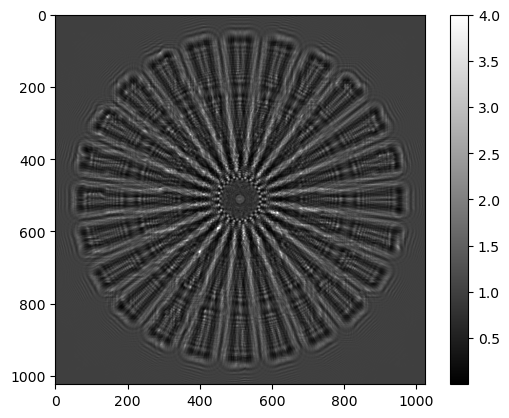

In [22]:

psi = np.ones([ntheta,ne,ne],dtype='complex64')
prb = np.ones([1,n+2*pad,n+2*pad],dtype='complex64')
d = np.abs(fwd_holo(psi,prb,code))**2

rdata = data00/d
plt.imshow(rdata[0,0],cmap='gray',vmax=4)
plt.colorbar()
plt.show()

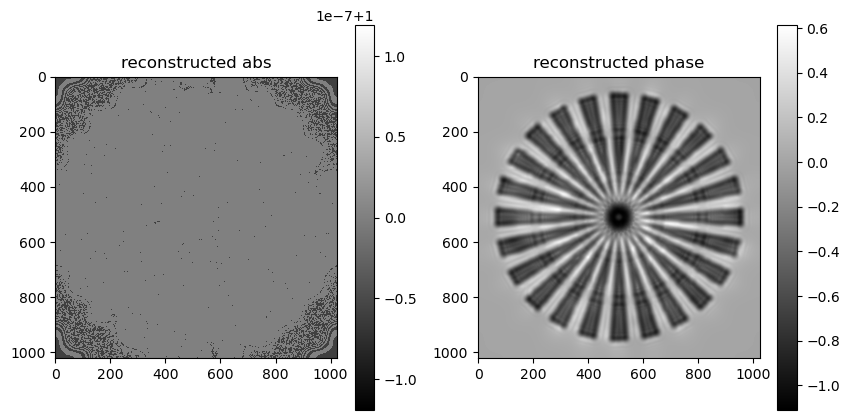

In [23]:
# distances should not be normalized
distances_pag = (distances/norm_magnifications**2)[:npos]
recMultiPaganin = np.exp(1j*multiPaganin(rdata,
                         distances_pag, wavelength, voxelsize,  19, 1e-12))
mshow(recMultiPaganin[0])

#### Main reconstruction. $\left\||\mathcal{G}_{z}(\mathcal{G}_{z'}(q\mathcal{S}_{s_{j}}c)\psi)|-\sqrt{d}\right\|_2^2\to min$

0) gamma=0.5, err=7.75108e+03


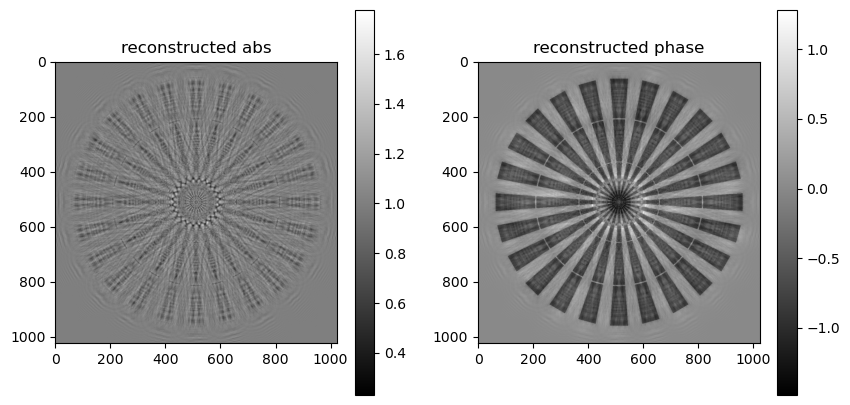

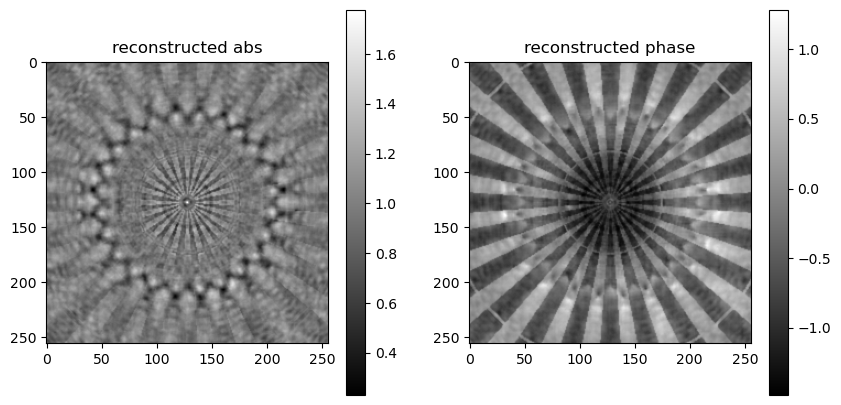

8) gamma=0.5, err=2.33598e+02
16) gamma=0.5, err=1.23587e+02
24) gamma=0.5, err=9.38273e+01
32) gamma=0.5, err=7.61471e+01


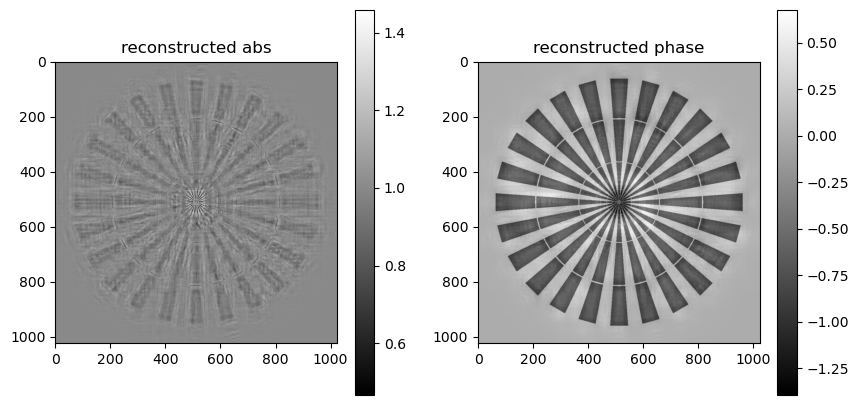

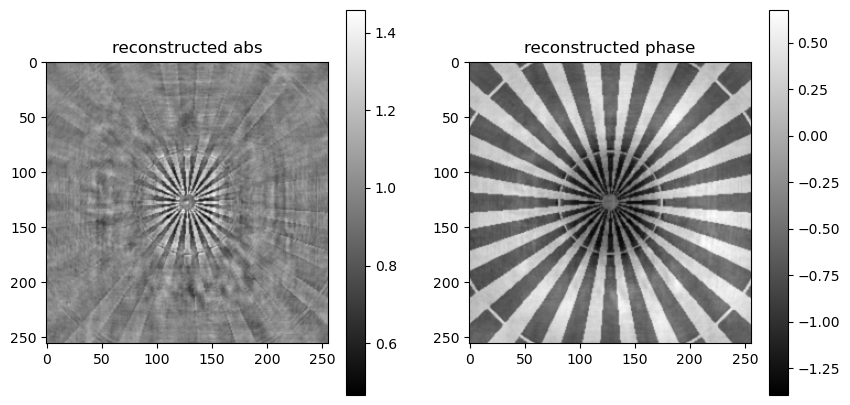

40) gamma=0.5, err=6.42008e+01
48) gamma=0.5, err=5.54087e+01
56) gamma=0.5, err=4.87460e+01
64) gamma=0.5, err=4.34455e+01


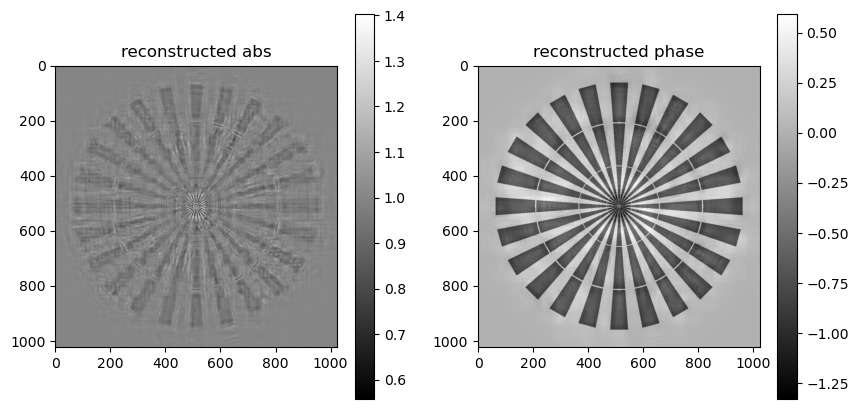

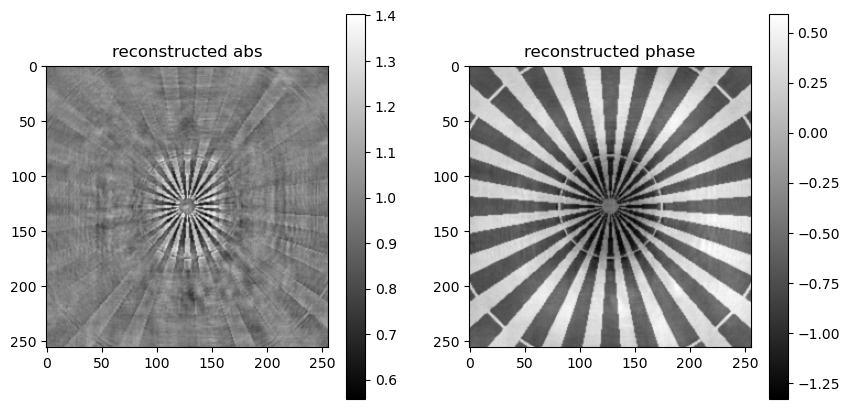

72) gamma=0.5, err=3.90740e+01
80) gamma=0.5, err=3.54914e+01
88) gamma=0.5, err=3.24695e+01
96) gamma=0.5, err=2.98613e+01


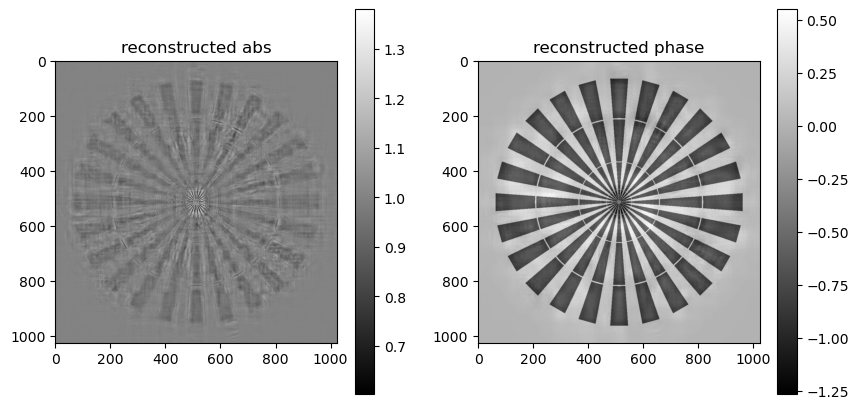

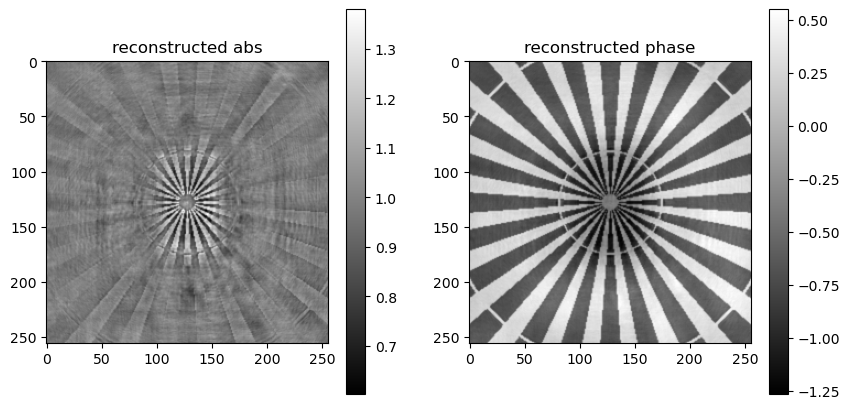

104) gamma=0.5, err=2.75788e+01
112) gamma=0.5, err=2.55979e+01
120) gamma=0.5, err=2.38693e+01
128) gamma=0.5, err=2.23441e+01


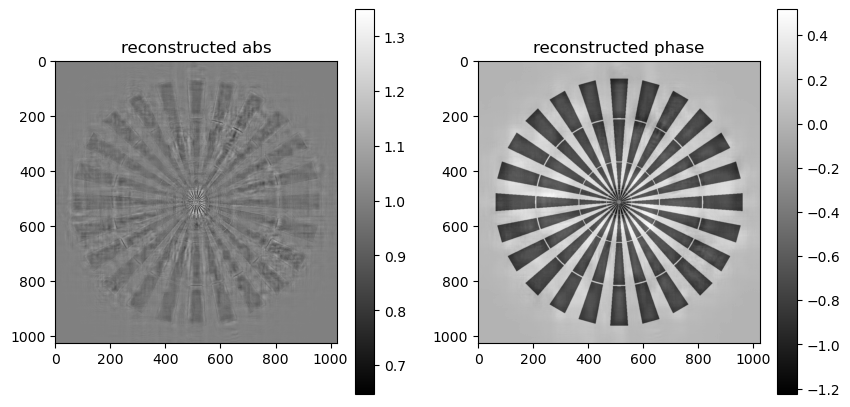

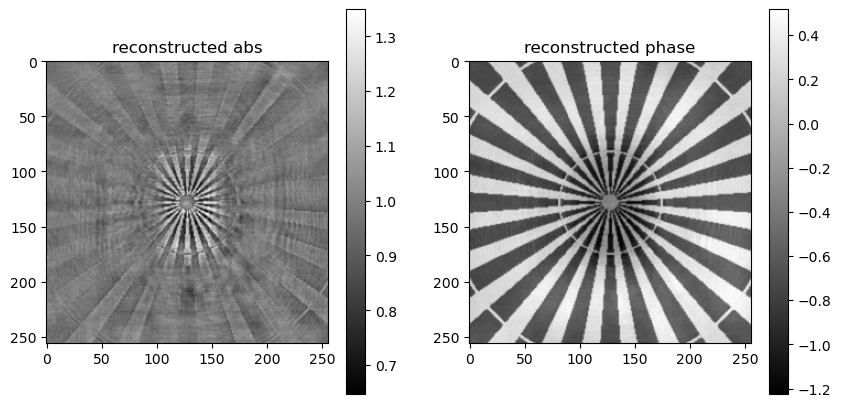

136) gamma=0.5, err=2.09863e+01
144) gamma=0.5, err=1.97683e+01
152) gamma=0.5, err=1.86699e+01
160) gamma=0.5, err=1.76740e+01


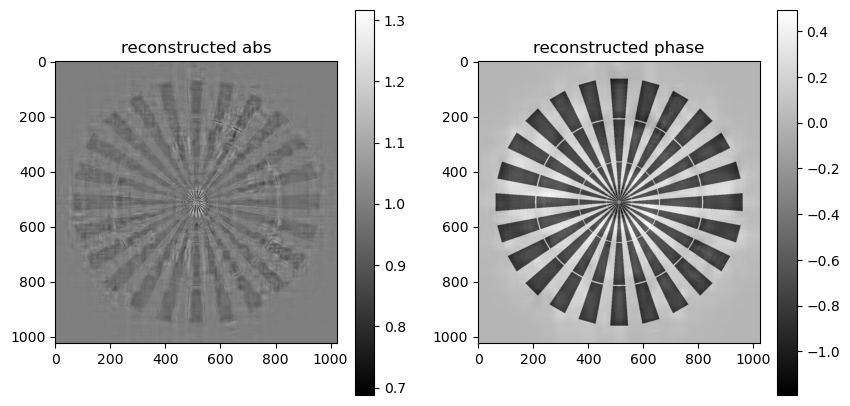

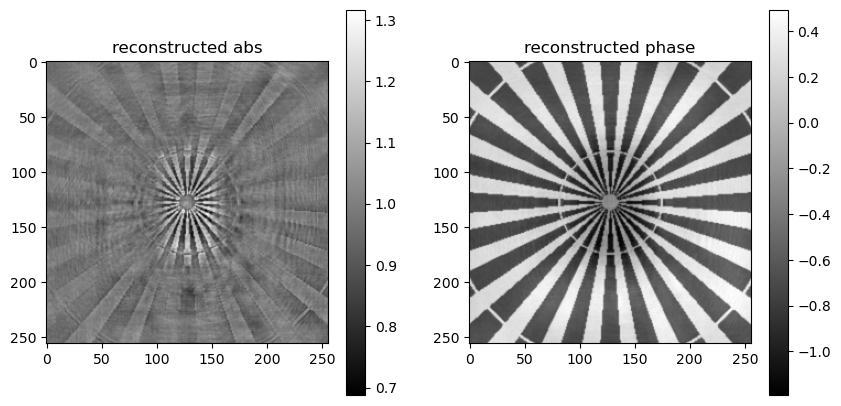

168) gamma=0.5, err=1.67675e+01
176) gamma=0.5, err=1.59405e+01
184) gamma=0.5, err=1.51839e+01
192) gamma=0.5, err=1.44650e+01


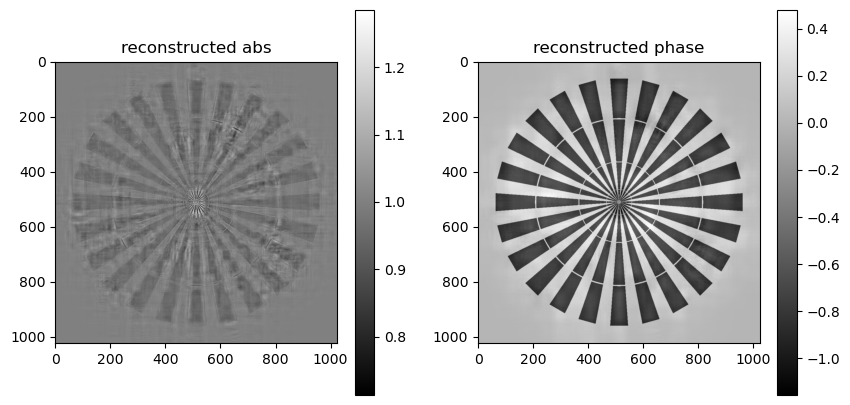

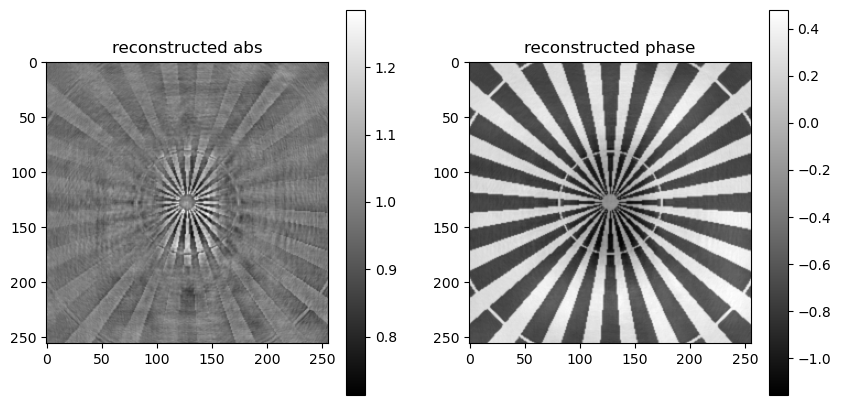

200) gamma=0.5, err=1.37533e+01
208) gamma=0.5, err=1.31522e+01
216) gamma=0.5, err=1.25926e+01
224) gamma=0.5, err=1.20638e+01


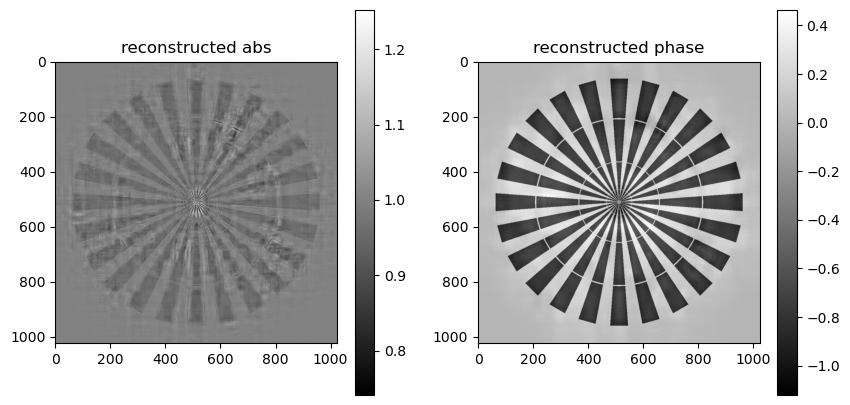

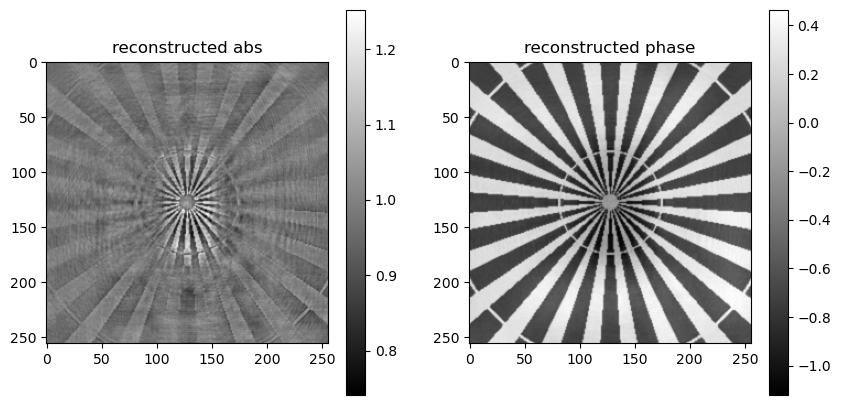

232) gamma=0.5, err=1.15690e+01
240) gamma=0.5, err=1.11184e+01
248) gamma=0.5, err=1.07084e+01
256) gamma=0.5, err=1.03281e+01


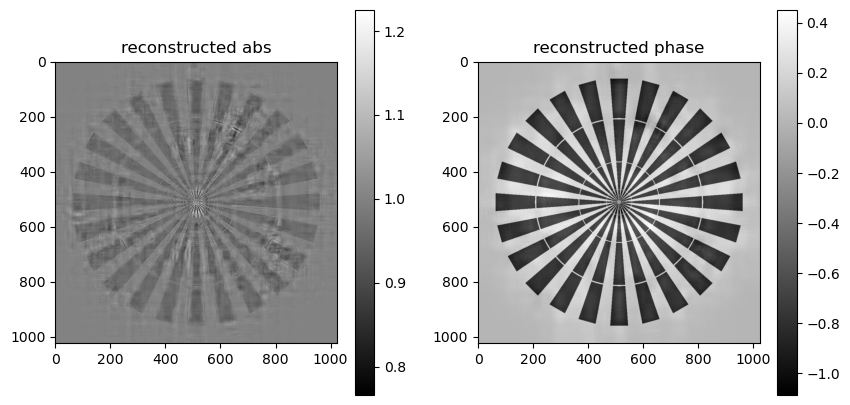

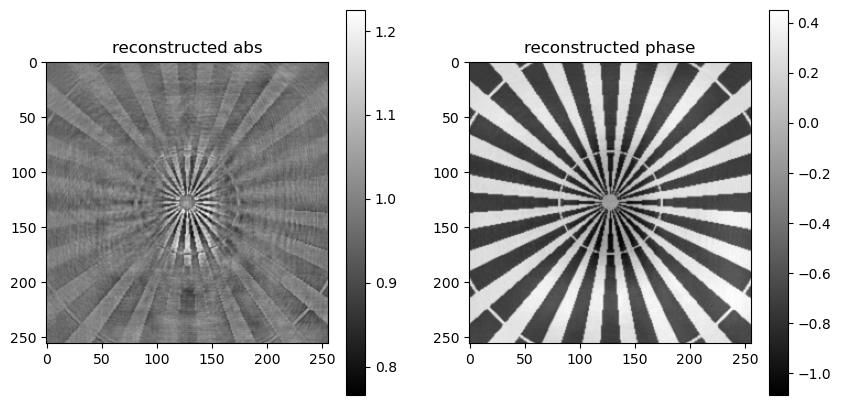

264) gamma=0.5, err=9.97403e+00
272) gamma=0.5, err=9.64329e+00
280) gamma=0.5, err=9.33344e+00
288) gamma=0.5, err=9.04225e+00


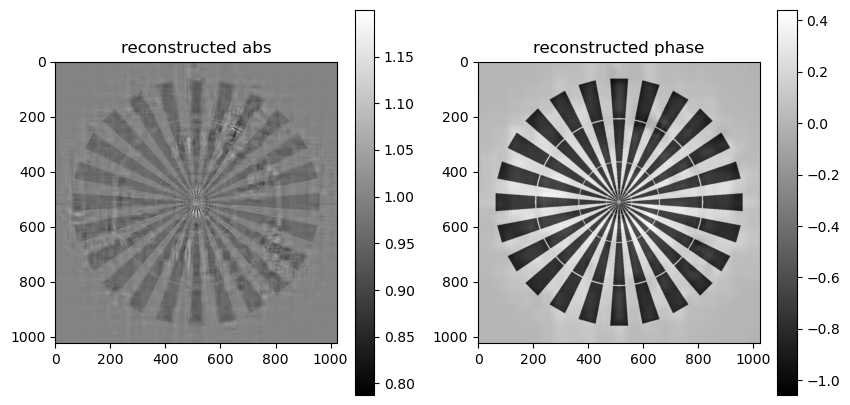

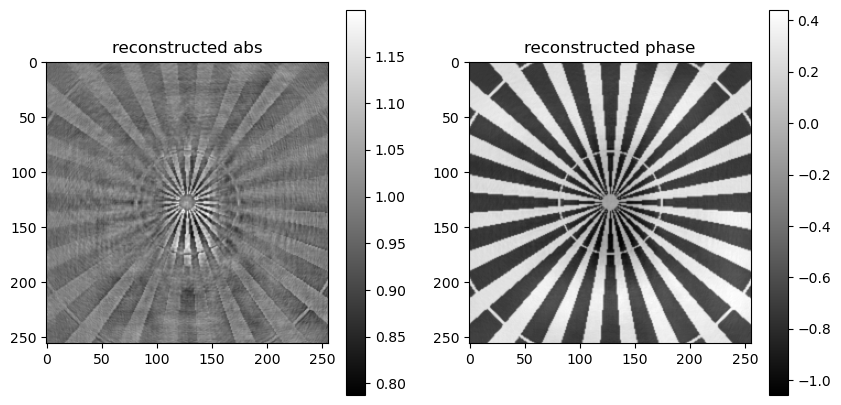

296) gamma=0.5, err=8.76901e+00
304) gamma=0.5, err=8.51167e+00
312) gamma=0.5, err=8.26964e+00
320) gamma=0.5, err=8.04163e+00


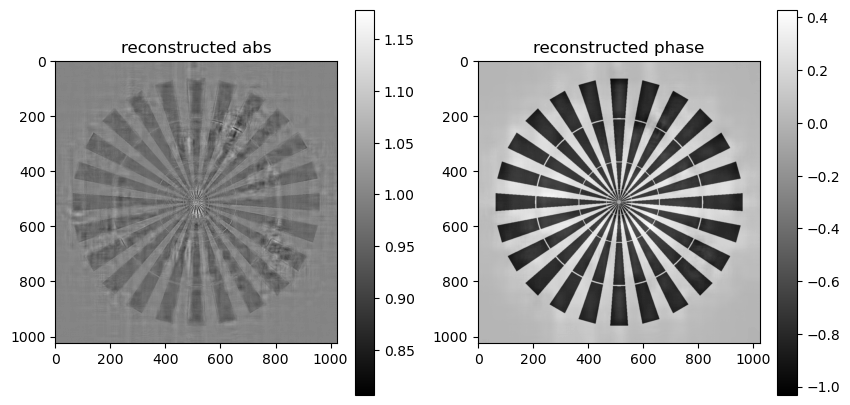

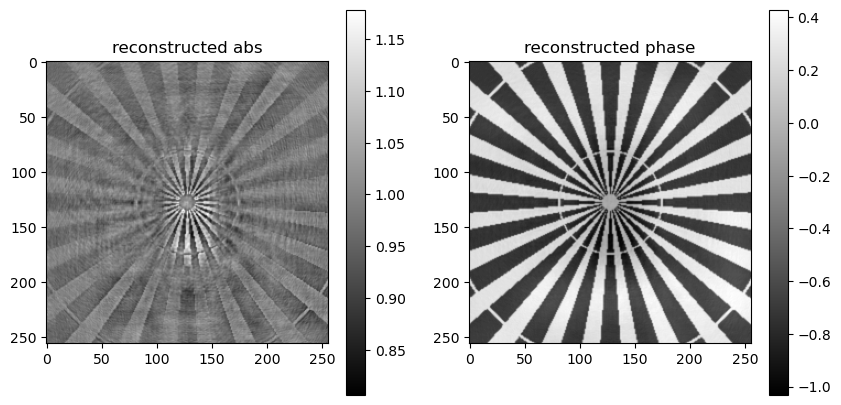

328) gamma=0.5, err=7.82641e+00
336) gamma=0.5, err=7.62306e+00
344) gamma=0.5, err=7.43070e+00
352) gamma=0.5, err=7.24844e+00


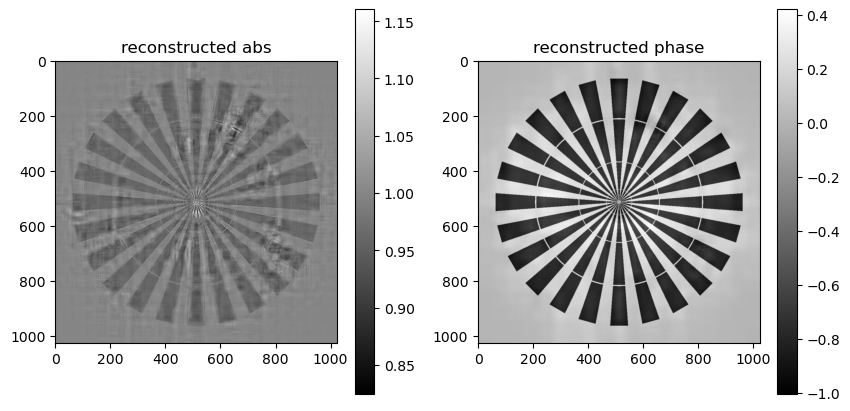

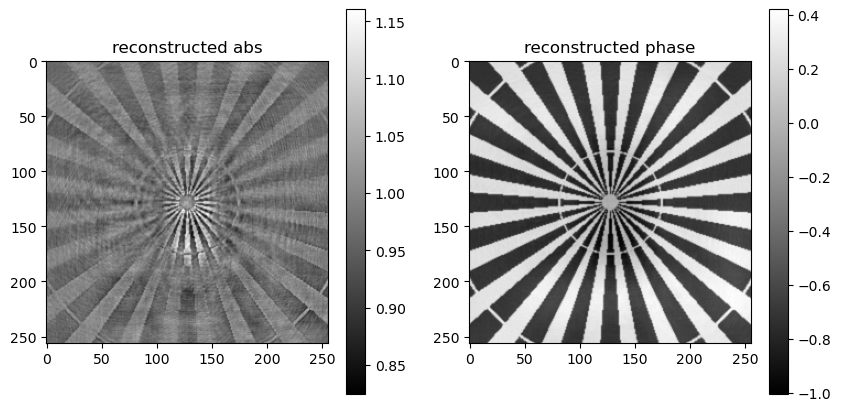

360) gamma=0.5, err=7.07388e+00
368) gamma=0.5, err=6.90742e+00
376) gamma=0.5, err=6.75185e+00
384) gamma=0.5, err=6.60421e+00


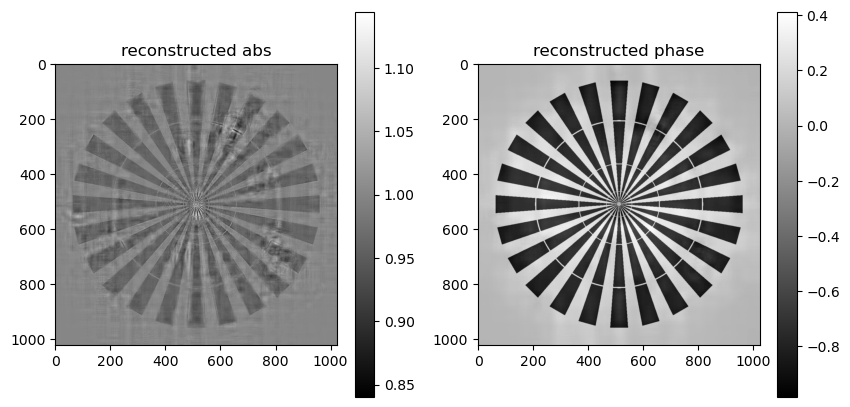

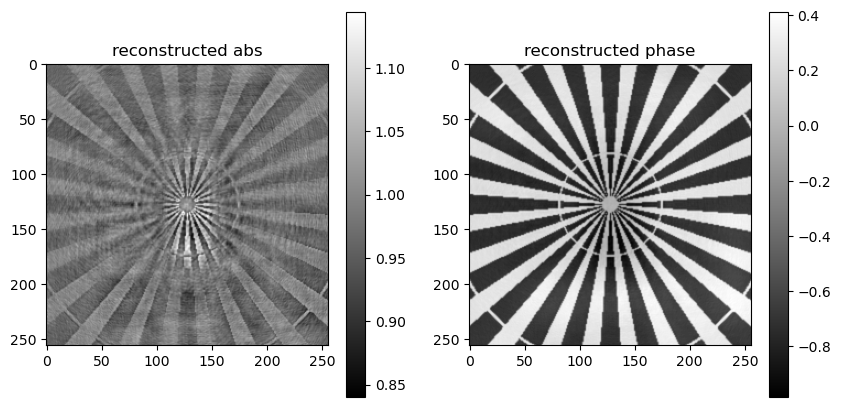

392) gamma=0.5, err=6.46358e+00
400) gamma=0.5, err=6.32323e+00
408) gamma=0.5, err=6.15694e+00
416) gamma=0.5, err=6.03373e+00


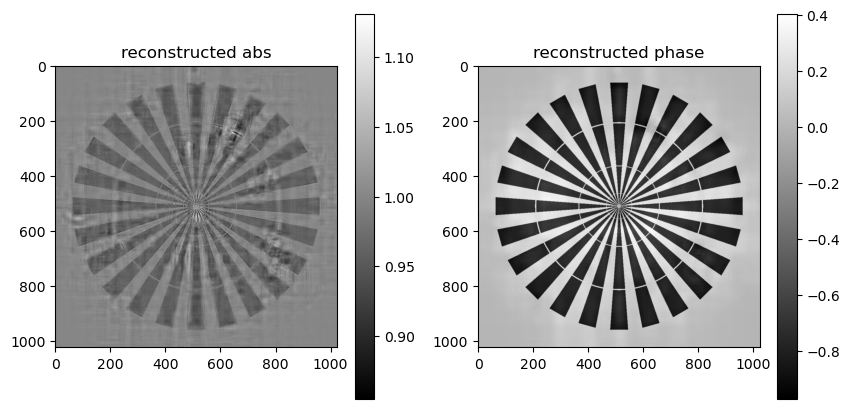

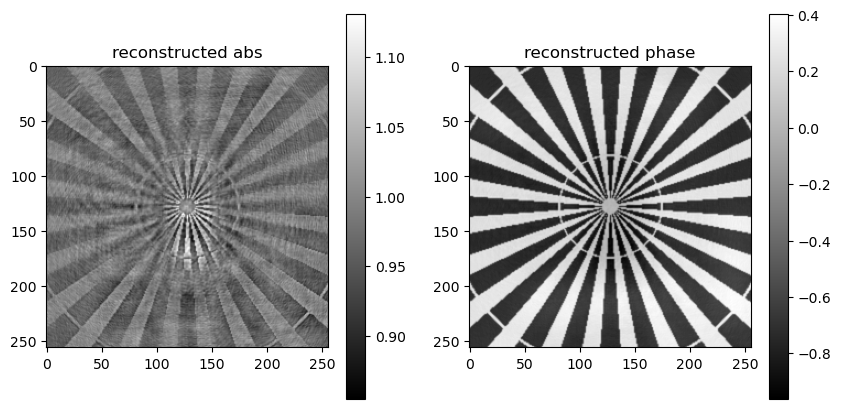

424) gamma=0.5, err=5.91830e+00
432) gamma=0.5, err=5.80833e+00
440) gamma=0.5, err=5.70339e+00
448) gamma=0.5, err=5.60316e+00


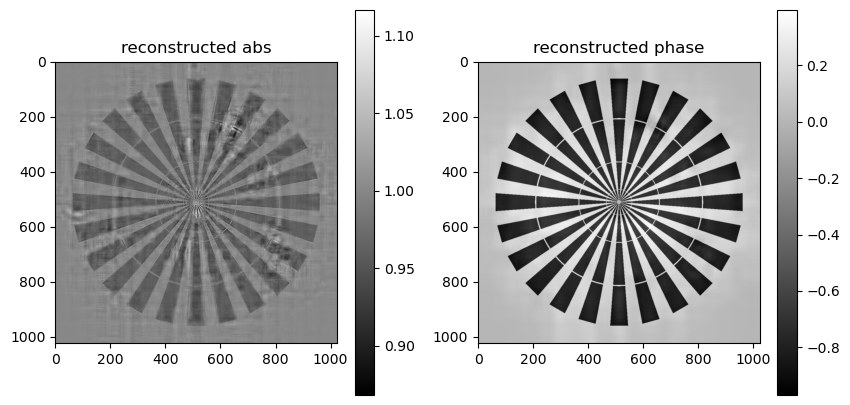

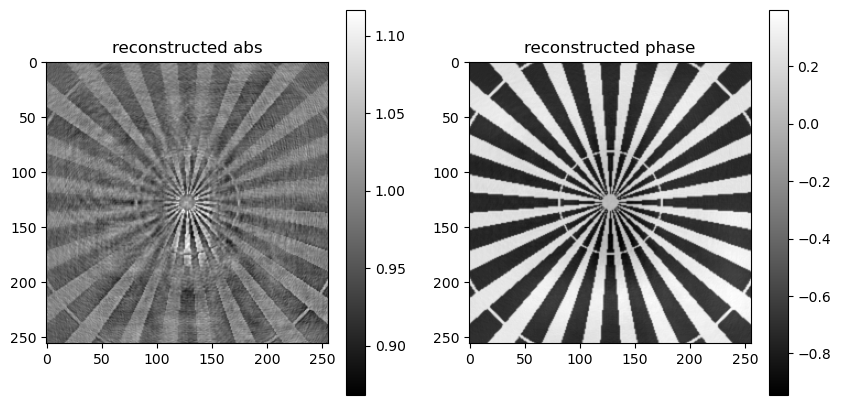

456) gamma=0.5, err=5.50736e+00
464) gamma=0.5, err=5.41566e+00
472) gamma=0.5, err=5.32775e+00
480) gamma=0.5, err=5.24369e+00


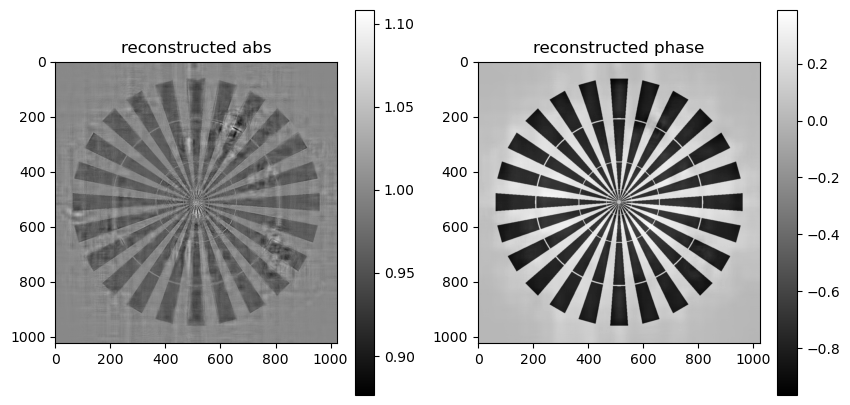

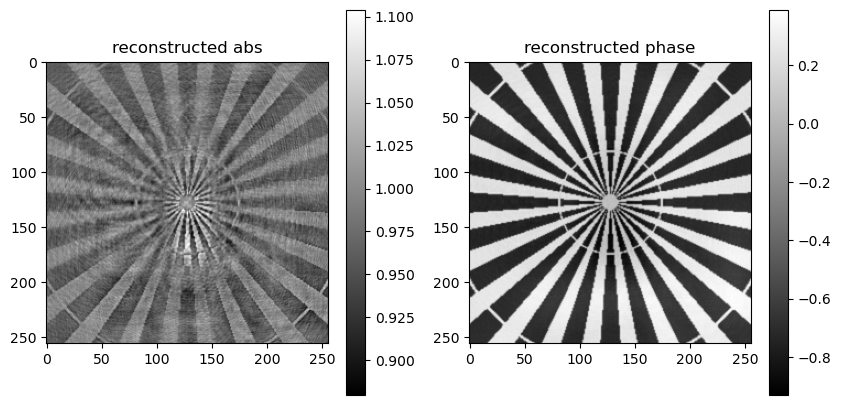

488) gamma=0.5, err=5.16311e+00
496) gamma=0.5, err=5.08561e+00
504) gamma=0.5, err=5.01133e+00
512) gamma=0.5, err=4.94027e+00


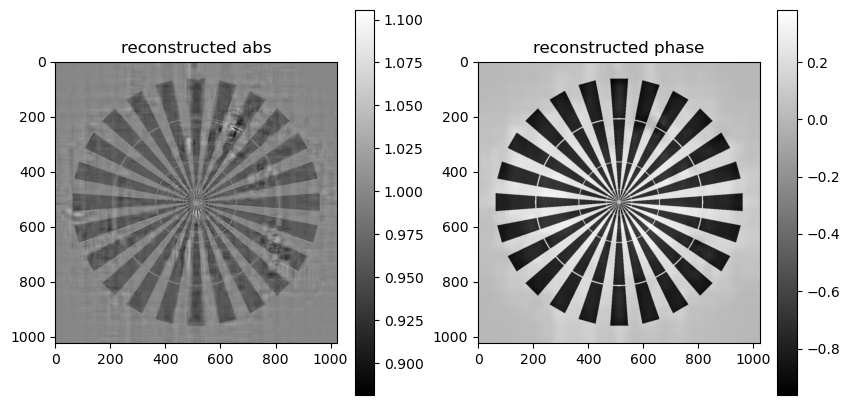

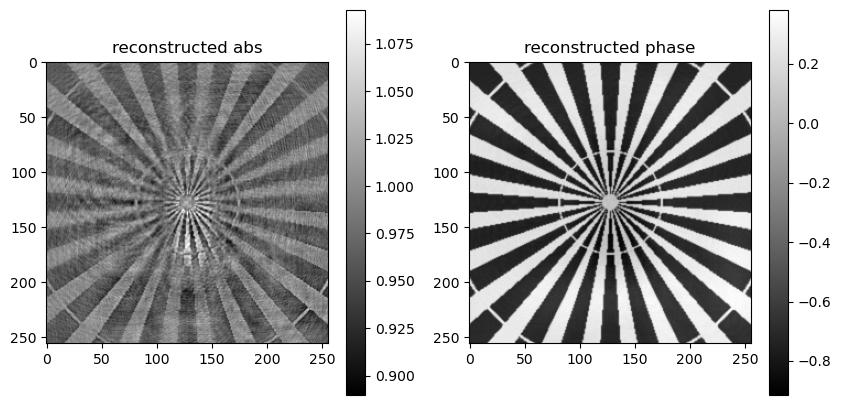

: 

In [24]:
def line_search(minf, gamma, fu, fd):
    """ Line search for the step sizes gamma"""
    while (minf(fu)-minf(fu+gamma*fd) < 0 and gamma > 1e-12):
        gamma *= 0.5
    if (gamma <= 1e-12):  # direction not found
        # print('no direction')
        gamma = 0
    return gamma


def cg_holo(data, init_psi,  pars):
    """Conjugate gradients method for holography"""
    # minimization functional
    def minf(fpsi):
        f = np.linalg.norm(np.abs(fpsi)-data)**2
        return f

    data = np.sqrt(data)
    psi = init_psi.copy()

    for i in range(pars['niter']):
        fpsi = fwd_holo(psi,prb,code)
        grad = adj_holo(fpsi-data*np.exp(1j*np.angle(fpsi)),prb,code)

        if i == 0:
            d = -grad
        else:
            d = dai_yuan(d,grad,grad0)
        grad0 = grad

        # line search
        fd = fwd_holo(d,prb,code)
        gamma = line_search(minf, pars['gammapsi'], fpsi, fd)
        psi += gamma*d

        if i % pars['err_step'] == 0:
            fpsi = fwd_holo(psi,prb,code)
            err = minf(fpsi)
            print(f'{i}) {gamma=}, {err=:1.5e}')

        if i % pars['vis_step'] == 0:
            mshow(psi[0])
            mshow(psi[0,ne//2-ne//8:ne//2+ne//8,ne//2-ne//8:ne//2+ne//8])

    return psi


# chunks on gpu
# rec_psi = np.pad(recMultiPaganin,((0,0),(ne//2-n//2,ne//2-n//2),(ne//2-n//2,ne//2-n//2)),'edge')
# data = data00.copy()

# fully on gpu
rec_psi = cp.array(np.pad(recMultiPaganin,((0,0),(ne//2-n//2,ne//2-n//2),(ne//2-n//2,ne//2-n//2)),'edge'))
data = cp.array(data00.copy())


pars = {'niter': 513, 'err_step': 8, 'vis_step': 32, 'gammapsi': 0.5}
rec_psi = cg_holo(data, rec_psi, pars)